<h1 style="color:blue; background:lightblue; line-height:1.5; text-align:center">* Quora Question Pair Similarity using BERT and ML Models*</h1>

<h2 style="color:blue; background:pink; line-height:1.5">Import required libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

<h2 style="color:blue; background:pink; line-height:1.5">Loading Dataset which has extracted features and Preprocessed</h2>

**Dataset link:** https://drive.google.com/file/d/1rxPJHAvSXzOPEpIqmaAsXvhJK8p4K4JN/view?usp=sharing

**Preprocessed Dataset link:** https://drive.google.com/file/d/1gKfuAAzJRs-l-0ftJgb-NQj8-PQrLqtn/view?usp=sharing

In [2]:
df=pd.read_csv('data/feat_extr_data.csv')
df.head()

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,what minor would complement a computer science...,what is a good minor that will compliment a co...,1,52,66,8,12,19,8,0.42,...,0.499996,1.0,1.0,4.0,10.0,0.547170,81,85,81,83
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,...,0.299997,1.0,0.0,4.0,8.0,0.433333,64,72,53,79
2,what was the happiest day of your life and why...,what was is will be the happiest day of your life,1,53,49,12,11,22,11,0.50,...,0.666661,0.0,1.0,1.0,11.5,0.600000,75,78,84,88
3,what role project manager has in agile projects,what is the role of project management in agil...,1,47,68,8,11,19,8,0.42,...,0.454541,0.0,1.0,3.0,9.5,0.312500,64,70,59,71
4,who will win in america presidential elections...,between trump and clinton who will win us pres...,1,54,63,9,10,18,8,0.44,...,0.399996,0.0,0.0,1.0,9.5,0.400000,60,77,65,68


<h2 style="color:blue; background:pink; line-height:1.5">Dataset information</h2>

In [3]:
df.shape

(49998, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49998 entries, 0 to 49997
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   question1           49998 non-null  object 
 1   question2           49998 non-null  object 
 2   is_duplicate        49998 non-null  int64  
 3   que1_len            49998 non-null  int64  
 4   que2_len            49998 non-null  int64  
 5   que1_num_words      49998 non-null  int64  
 6   que2_num_words      49998 non-null  int64  
 7   total_words         49998 non-null  int64  
 8   common_words        49998 non-null  int64  
 9   shared_words        49998 non-null  float64
 10  cwc_min             49998 non-null  float64
 11  cwc_max             49998 non-null  float64
 12  csc_min             49998 non-null  float64
 13  csc_max             49998 non-null  float64
 14  ctc_min             49998 non-null  float64
 15  ctc_max             49998 non-null  float64
 16  last

<h2 style="color:blue; background:pink; line-height:1.5">Missing values</h2>

In [5]:
df.isnull().sum()

question1             0
question2             0
is_duplicate          0
que1_len              0
que2_len              0
que1_num_words        0
que2_num_words        0
total_words           0
common_words          0
shared_words          0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
last_word_eq          0
first_word_eq         0
abs_len_diff          0
mean_len              0
long_substr_ratio     0
fuzz_ratio            0
fuzz_partial_ratio    0
token_sort_ratio      0
token_set_ratio       0
dtype: int64

<h2 style="color:blue; background:pink; line-height:1.5">Data Balance check</h2>

In [6]:
class_balance=pd.DataFrame(df['is_duplicate'].value_counts()).reset_index()
class_balance.columns=["Class", "Count"]
class_balance['Percentage']=(class_balance['Count']/df.shape[0])*100
class_balance

,Class,Count,Percentage
0,1,25000,50.002
1,0,24998,49.998


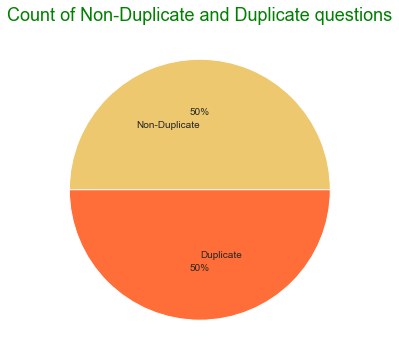

In [7]:
label=['Non-Duplicate', 'Duplicate'] 
color=sns.color_palette('rainbow')[4:6]
plt.figure(figsize=(6,6))
plt.pie(x=class_balance['Count'], labels=label, colors=color, autopct='%.0f%%' , labeldistance=0.5)
plt.title("Count of Non-Duplicate and Duplicate questions", fontsize=18, color='green');

<h2 style="color:blue; background:pink; line-height:1.5">Combine question1 and question2</h2>

In [8]:
data=df[['is_duplicate','question1','question2']]
data['combine_question']=data['question1']+" "+data['question2']
data.head(2)

,is_duplicate,question1,question2,combine_question
0,1,what minor would complement a computer science...,what is a good minor that will compliment a co...,what minor would complement a computer science...
1,1,how can i materialize an idea,what is the best way to materialize on an idea,how can i materialize an idea what is the best...


<h2 style="color:blue; background:pink; line-height:1.5">Input and output feaures</h2>

In [9]:
X=data.drop('is_duplicate', axis=1)
y=data['is_duplicate']
print(X.shape, y.shape)

(49998, 3) (49998,)


<h2 style="color:blue; background:pink; line-height:1.5">Train Test Split</h2>

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("x train shape=", x_train.shape)
print("y train shape=", y_train.shape)
print("x test shape=", x_test.shape)
print("y test shape=", y_test.shape)

x train shape= (39998, 3)
y train shape= (39998,)
x test shape= (10000, 3)
y test shape= (10000,)


### No need of text preprocessing because we loaded clean data

<h2 style="color:blue; background:pink; line-height:1.5">Convert Text to Numerical Sentence Vectors using BERT</h2>

In [11]:
!pip install -U sentence-transformers

  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=bd6351a65b371562d5e517d2d33744ff60cbcc7975ed6010acb90d7fcfcd6257
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\71\67\06\162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [12]:
from sentence_transformers import SentenceTransformer, util
model=SentenceTransformer('all-MiniLM-L6-v2')

<h2 style="color:blue; background:pink; line-height:1.5">Convert Clean Text to Documents Vectors</h2>

In [13]:
x_train['doc_vector']=x_train['combine_question'].apply(model.encode)
x_test['doc_vector']=x_test['combine_question'].apply(model.encode)
x_train.head(2)

,question1,question2,combine_question,doc_vector
39085,which laptop should i buy under 60k,which laptop should i buy under 60k,which laptop should i buy under 60k which lapt...,"[-0.011452393, 0.08359903, -0.03809174, 0.0312..."
30892,how hair grow after hair transplant surgery,how long does a hair transplant surgery take,how hair grow after hair transplant surgery ho...,"[0.019064082, 0.0018240447, 0.0182498, -0.0501..."


In [14]:
x_test.head(2)

,question1,question2,combine_question,doc_vector
33552,i am skinny fat what strategy should i follow ...,what will be future for r profile within few y...,i am skinny fat what strategy should i follow ...,"[-0.014005228, -0.0037971667, -0.027306147, 0...."
9427,do rich people worry about anything,what do wealthy people worry about,do rich people worry about anything what do we...,"[0.12070254, 0.02946615, -0.028693503, 0.08008..."


<h2 style="color:blue; background:pink; line-height:1.5">Final Training and Testing Input data</h2>

In [15]:
x_train=list(x_train['doc_vector'])
x_test=list(x_test['doc_vector'])
x_train[1]

array([ 1.90640818e-02,  1.82404474e-03,  1.82498004e-02, -5.01856878e-02,
       -3.13632265e-02, -7.25100283e-03, -9.22159664e-03, -1.80835892e-02,
       -2.24100407e-02,  1.25865021e-03,  1.32547528e-01,  1.79323182e-02,
        3.10442895e-02, -5.10033630e-02, -2.58102510e-02,  1.20200016e-01,
       -5.39968088e-02, -4.50595059e-02, -8.90304148e-02,  4.58458019e-03,
        3.96650657e-02, -8.00943896e-02, -2.89120451e-02,  1.14627667e-02,
        9.53951553e-02, -1.32833673e-02, -3.79500240e-02, -1.20905079e-02,
       -3.11895926e-02,  1.75824296e-02, -2.75257174e-02,  3.30171250e-02,
       -2.69643646e-02, -1.93904359e-02, -4.38627936e-02, -1.02947745e-02,
       -1.83569244e-03, -1.23903388e-02, -1.91018498e-03, -5.51283062e-02,
       -4.32366617e-02, -5.19650709e-03, -2.17425283e-02, -9.82692465e-04,
        5.02833053e-02, -3.67170498e-02, -9.93330404e-03,  3.64179350e-02,
       -3.04683167e-02, -3.42219621e-02, -6.20147176e-02, -2.29951069e-02,
       -2.69114319e-02, -

In [16]:
x_test[1]

array([ 1.20702542e-01,  2.94661503e-02, -2.86935028e-02,  8.00869092e-02,
        3.89416330e-02, -4.25740890e-02,  1.29374534e-01, -1.24467611e-02,
       -5.51408380e-02, -4.58761454e-02,  2.57944688e-02,  2.63755042e-02,
        3.56546864e-02, -1.29767761e-01, -7.87931904e-02, -1.72398426e-02,
       -4.54453044e-02, -5.03273457e-02, -1.75064072e-01,  8.35555270e-02,
       -7.43232146e-02, -4.35352921e-02, -1.49850855e-02,  2.88499258e-02,
       -3.17927659e-03, -5.61316423e-02,  3.74312811e-02, -1.89720541e-02,
       -1.22188358e-02,  5.65992109e-02, -1.92092787e-02, -4.63980772e-02,
        4.30549011e-02, -3.18516046e-02, -8.07526801e-03,  1.31526189e-02,
        9.96803567e-02,  4.32033837e-03, -1.31602939e-02, -8.30737203e-02,
        3.38110980e-03, -4.67063338e-02,  2.08991896e-02, -7.02560833e-03,
       -4.97732125e-02, -9.52271670e-02,  4.56344001e-02, -8.37497786e-02,
        1.71702716e-03, -5.77651709e-02, -4.98370379e-02, -5.94796166e-02,
        4.37146984e-02, -

<h2 style="color:blue; background:pink; line-height:1.5">Building model</h2>

<h2 style="color:blue; background:pink;">Set Experiment<h2>

In [17]:
import mlflow
mlflow.set_experiment("Advance_approach_using_pre_trained_models")

<Experiment: artifact_location='file:///D:/DATA%20SCIENCE%20Internship%20with%20Innomatics/Final_%20Project_Quora_Question_Pair_Similarity/mlruns/591167485821976991', creation_time=1685863390057, experiment_id='591167485821976991', last_update_time=1685863390057, lifecycle_stage='active', name='Advance_approach_using_pre_trained_models', tags={}>

<h2 style="color:blue; background:lightgreen; line-height:1">1. Logistic Regression<h2>

----------------------------------------------------------
Acuuracy=0.7109
Precission=0.7139987949387427
Recall=0.7078853046594982
F1 Score=0.7109289071092891
----------------------------------------------------------
Confusion Matrix=



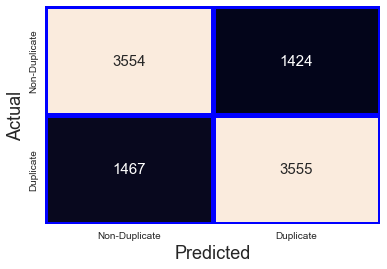

----------------------------------------------------------
Out of 10000 testing values 2891 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.71      0.71      0.71      4978
           1       0.71      0.71      0.71      5022

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

----------------------------------------------------------


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Logistic bert")
    
    log_regression=LogisticRegression()
    log_regression.fit(x_train,y_train)
    pickle.dump(log_regression, open("resources_advance_approach_using_pre_trained_model/logistic_regression_bert.pkl","wb"))
    
    y_pred=log_regression.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/log_reg_bert_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(log_regression, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/log_reg_bert_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">2. Naive Bayes<h2>

----------------------------------------------------------
Acuuracy=0.6654
Precission=0.6822531535450196
Recall=0.6246515332536838
F1 Score=0.6521829521829522
----------------------------------------------------------
Confusion Matrix=



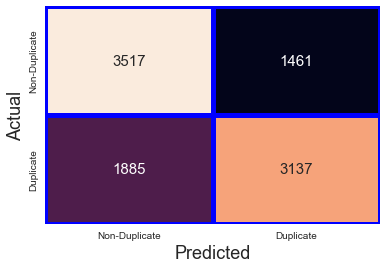

----------------------------------------------------------
Out of 10000 testing values 3346 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.65      0.71      0.68      4978
           1       0.68      0.62      0.65      5022

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.66     10000
weighted avg       0.67      0.67      0.66     10000

----------------------------------------------------------


In [20]:
from sklearn.naive_bayes import GaussianNB
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Naive Bayes bert")
    
    naive_classifier=GaussianNB()
    naive_classifier.fit(x_train,y_train)
    pickle.dump(naive_classifier, open("resources_advance_approach_using_pre_trained_model/naive_bert.pkl","wb"))
    
    y_pred=naive_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/naive_bert_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(naive_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/naive_bert_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">3. Decision Tree</h2>

----------------------------------------------------------
Acuuracy=0.604
Precission=0.6044453186467349
Recall=0.6119076065312624
F1 Score=0.6081535721353651
----------------------------------------------------------
Confusion Matrix=



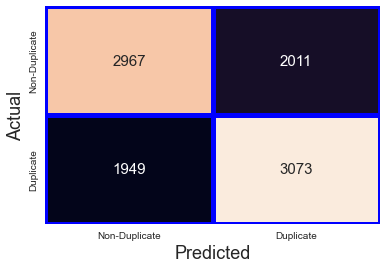

----------------------------------------------------------
Out of 10000 testing values 3960 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.60      0.60      0.60      4978
           1       0.60      0.61      0.61      5022

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000

----------------------------------------------------------


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Decision Tree bert")
    
    dt_classifier=DecisionTreeClassifier()
    dt_classifier.fit(x_train,y_train)
    pickle.dump(dt_classifier, open("resources_advance_approach_using_pre_trained_model/decision_tree_bert.pkl","wb"))
    
    y_pred=dt_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/decision_tree_bert_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(dt_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/decision_tree_bert_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">4. Random Forest</h2>

----------------------------------------------------------
Acuuracy=0.7285
Precission=0.7868689380751057
Recall=0.6300278773397053
F1 Score=0.699767776180471
----------------------------------------------------------
Confusion Matrix=



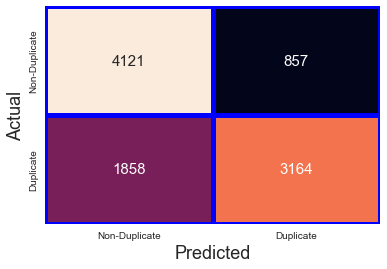

----------------------------------------------------------
Out of 10000 testing values 2715 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.69      0.83      0.75      4978
           1       0.79      0.63      0.70      5022

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000

----------------------------------------------------------


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Random Forest bert")
    
    rf_classifier=RandomForestClassifier()
    rf_classifier.fit(x_train,y_train)
    pickle.dump(rf_classifier, open("resources_advance_approach_using_pre_trained_model/random_forest_bert.pkl","wb"))
    
    y_pred=rf_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/random_forest_bert_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(rf_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/random_forest_bert_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">5. Gradient Boosting</h2>

----------------------------------------------------------
Acuuracy=0.6878
Precission=0.7009306260575296
Recall=0.6598964555953803
F1 Score=0.6797948717948719
----------------------------------------------------------
Confusion Matrix=



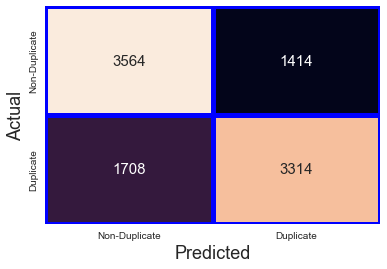

----------------------------------------------------------
Out of 10000 testing values 3122 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      4978
           1       0.70      0.66      0.68      5022

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

----------------------------------------------------------


In [23]:
from sklearn.ensemble import GradientBoostingClassifier
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Gradient Boost bert")
    
    gb_classifier=GradientBoostingClassifier()
    gb_classifier.fit(x_train,y_train)
    pickle.dump(gb_classifier, open("resources_advance_approach_using_pre_trained_model/gradient_boostig_bert.pkl","wb"))
    
    y_pred=gb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/gradient_boost_bert_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(gb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/gradient_boost_bert_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">6. Ada Boost</h2>

----------------------------------------------------------
Acuuracy=0.6473
Precission=0.6534592486142475
Recall=0.6338112305854241
F1 Score=0.6434852926311533
----------------------------------------------------------
Confusion Matrix=



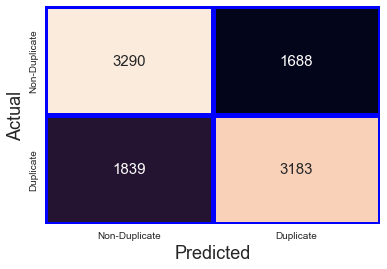

----------------------------------------------------------
Out of 10000 testing values 3527 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.64      0.66      0.65      4978
           1       0.65      0.63      0.64      5022

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000

----------------------------------------------------------


In [24]:
from sklearn.ensemble import AdaBoostClassifier
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Ada Boost bert")
    
    ada_classifier=AdaBoostClassifier()
    ada_classifier.fit(x_train,y_train)
    pickle.dump(ada_classifier, open("resources_advance_approach_using_pre_trained_model/ada_boosting_bert.pkl","wb"))
    
    y_pred=ada_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/ada_boost_bert_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(ada_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/ada_boost_bert_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1">7. XG Boost</h2>

----------------------------------------------------------
Acuuracy=0.737
Precission=0.7441812984891792
Recall=0.7258064516129032
F1 Score=0.7348790322580646
----------------------------------------------------------
Confusion Matrix=



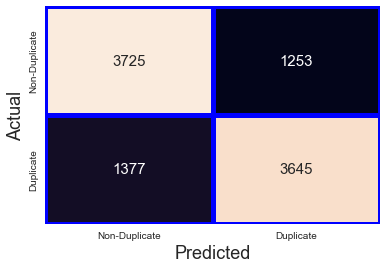

----------------------------------------------------------
Out of 10000 testing values 2630 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.73      0.75      0.74      4978
           1       0.74      0.73      0.73      5022

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

----------------------------------------------------------


In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "XG Boost bert")
    
    xgb_classifier=XGBClassifier()
    xgb_classifier.fit(x_train,y_train)
    pickle.dump(xgb_classifier, open("resources_advance_approach_using_pre_trained_model/xgboost_bert.pkl","wb"))
    
    y_pred=xgb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/xgboost_bert_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(xgb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/xgboost_bert_conf_matrix.png")

### Inference:
 **Accuracy of XGBoost model is high(74%).**

**+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+**

<h1 style="color:blue; background:lightblue; line-height:1.5; text-align:center">* Quora Question Pair Similarity using BERT, Extracted features and ML Models*</h1>

<h2 style="color:blue; background:pink; line-height:1.5">Load Clean Dataset</h2>

In [26]:
df.head()

,question1,question2,is_duplicate,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,what minor would complement a computer science...,what is a good minor that will compliment a co...,1,52,66,8,12,19,8,0.42,...,0.499996,1.0,1.0,4.0,10.0,0.547170,81,85,81,83
1,how can i materialize an idea,what is the best way to materialize on an idea,1,29,46,6,10,16,2,0.12,...,0.299997,1.0,0.0,4.0,8.0,0.433333,64,72,53,79
2,what was the happiest day of your life and why...,what was is will be the happiest day of your life,1,53,49,12,11,22,11,0.50,...,0.666661,0.0,1.0,1.0,11.5,0.600000,75,78,84,88
3,what role project manager has in agile projects,what is the role of project management in agil...,1,47,68,8,11,19,8,0.42,...,0.454541,0.0,1.0,3.0,9.5,0.312500,64,70,59,71
4,who will win in america presidential elections...,between trump and clinton who will win us pres...,1,54,63,9,10,18,8,0.44,...,0.399996,0.0,0.0,1.0,9.5,0.400000,60,77,65,68


<h2 style="color:blue; background:pink; line-height:1.5">Divide data into Input and Output</h2>

In [27]:
X=df.drop('is_duplicate', axis=1)
y=df['is_duplicate']
print(X.shape, y.shape)

(49998, 24) (49998,)


<h2 style="color:blue; background:pink; line-height:1.5">Seperate Extracted features and apply word embedding to Question1 and Question2 Seperately and while splitting train test concatenate extracted features.</h2>

In [28]:
questions1=list(X['question1'])
questions2=list(X['question2'])
print(questions1[:2])
print(questions2[:2])

['what minor would complement a computer science major', 'how can i materialize an idea']
['what is a good minor that will compliment a computer science major', 'what is the best way to materialize on an idea']


In [29]:
extracted_features=['que1_len', 'que2_len',
       'que1_num_words', 'que2_num_words', 'total_words', 'common_words',
       'shared_words', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
       'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'long_substr_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio']

extracted_features=X[extracted_features]
extracted_features[:5]

,que1_len,que2_len,que1_num_words,que2_num_words,total_words,common_words,shared_words,cwc_min,cwc_max,csc_min,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,long_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,52,66,8,12,19,8,0.42,0.666656,0.666656,0.999950,...,0.499996,1.0,1.0,4.0,10.0,0.547170,81,85,81,83
1,29,46,6,10,16,2,0.12,0.999950,0.499988,0.249994,...,0.299997,1.0,0.0,4.0,8.0,0.433333,64,72,53,79
2,53,49,12,11,22,11,0.50,0.999967,0.999967,0.624992,...,0.666661,0.0,1.0,1.0,11.5,0.600000,75,78,84,88
3,47,68,8,11,19,8,0.42,0.599988,0.499992,0.666644,...,0.454541,0.0,1.0,3.0,9.5,0.312500,64,70,59,71
4,54,63,9,10,18,8,0.44,0.399992,0.333328,0.666644,...,0.399996,0.0,0.0,1.0,9.5,0.400000,60,77,65,68


<h2 style="color:blue; background:pink; line-height:1.5">Create Document vector using pre-trained BERT</h2>

In [30]:
doc_vector1=list(X['question1'].apply(model.encode))
doc_vector2=list(X['question2'].apply(model.encode))
doc_vector1[1]

array([-5.69832511e-02,  3.21483836e-02,  3.56425047e-02, -1.28246667e-02,
        5.79713322e-02,  2.76717227e-02,  6.75143749e-02,  7.41180554e-02,
       -1.96705814e-02,  6.69298172e-02, -1.39749780e-01,  1.59743370e-03,
       -4.61229542e-03,  4.79702130e-02, -1.20710656e-02, -3.37790400e-02,
        4.07117084e-02,  3.15812156e-02, -4.67915125e-02, -2.44256966e-02,
        4.41854969e-02,  2.33329237e-02,  1.79691203e-02, -1.14569198e-02,
       -8.66125710e-03,  8.73558521e-02,  8.31238553e-02, -3.63886170e-02,
        7.89543092e-02, -5.54883145e-02,  4.84597869e-02,  7.84342661e-02,
       -5.81536721e-03, -4.88369865e-03,  6.78026816e-03,  1.42397568e-01,
       -5.65004200e-02,  7.60665685e-02,  2.58181449e-02, -8.59635696e-02,
       -7.78953731e-02, -2.21426468e-02, -5.15497848e-03,  2.68387105e-02,
        1.08901635e-01, -1.07628539e-01,  4.02475595e-02, -1.99302100e-02,
        5.34186848e-02, -3.59151736e-02, -3.59780192e-02, -7.94058889e-02,
       -4.23459969e-02, -

In [31]:
doc_vector2[1]

array([-6.20567314e-02,  5.39890118e-02,  2.93683093e-02, -2.33581234e-02,
        5.62864244e-02,  2.61585396e-02,  6.58342540e-02,  8.76721889e-02,
        1.94700633e-03,  7.35021532e-02, -1.24935851e-01,  3.31838280e-02,
       -2.02498976e-02,  5.67612201e-02, -7.64385052e-03, -4.16389145e-02,
        5.41087054e-02,  5.79914972e-02, -3.28915901e-02, -2.59643067e-02,
        2.33133957e-02,  4.10606526e-03,  2.06255354e-02, -9.57493950e-03,
        2.73575727e-02,  7.26657137e-02,  8.25548321e-02, -4.13578711e-02,
        8.73708278e-02, -5.55741899e-02,  2.58158557e-02,  8.47959965e-02,
       -5.72243892e-03, -2.95786932e-03, -2.33343132e-02,  1.53466418e-01,
       -4.76352125e-02,  8.42541307e-02,  3.41713503e-02, -8.92207399e-02,
       -8.43812749e-02, -7.89517944e-04, -1.11386208e-02,  2.00423989e-02,
        1.08121246e-01, -1.01457343e-01,  5.75345345e-02, -3.31759406e-03,
        6.11875243e-02, -2.58813016e-02, -3.53461727e-02, -7.21092969e-02,
       -5.16545065e-02, -

<h2 style="color:blue; background:pink; line-height:1.5">Finalizing input and output features</h2>

In [32]:
extracted_features_array=np.array(extracted_features)
embedded_document_array=np.hstack((doc_vector1, doc_vector2))
X_final=np.hstack((extracted_features_array, embedded_document_array))
y_final=np.array(y)
print(X_final.shape, y_final.shape)

(49998, 790) (49998,)


<h2 style="color:blue; background:pink; line-height:1.5">Train test split</h2>

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)
print(x_train.shape, y_train.shape,x_test.shape,y_test.shape)

(39998, 790) (39998,) (10000, 790) (10000,)


<h2 style="color:blue; background:lightgreen; line-height:1.5">XG Boost</h2>

----------------------------------------------------------
Acuuracy=0.8251
Precission=0.7987949607449334
Recall=0.8711668657905217
F1 Score=0.8334127059719975
----------------------------------------------------------
Confusion Matrix=



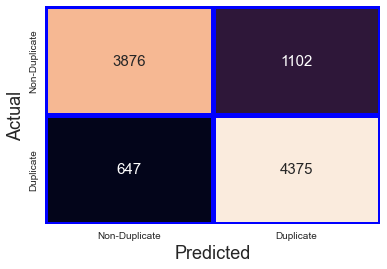

----------------------------------------------------------
Out of 10000 testing values 1749 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      4978
           1       0.80      0.87      0.83      5022

    accuracy                           0.83     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.83      0.82     10000

----------------------------------------------------------


In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "XG Boost bert extr")
    
    xgb_classifier=XGBClassifier()
    xgb_classifier.fit(x_train,y_train)
    pickle.dump(xgb_classifier, open("resources_advance_approach_using_pre_trained_model/xgboost_bert_extr.pkl","wb"))
    
    y_pred=xgb_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/xgboost_bert_extr_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(xgb_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/xgboost_bert_extr_conf_matrix.png")

<h2 style="color:blue; background:lightgreen; line-height:1.5">Random Forest</h2>

----------------------------------------------------------
Acuuracy=0.7915
Precission=0.7436535589845694
Recall=0.8924731182795699
F1 Score=0.8112951398316589
----------------------------------------------------------
Confusion Matrix=



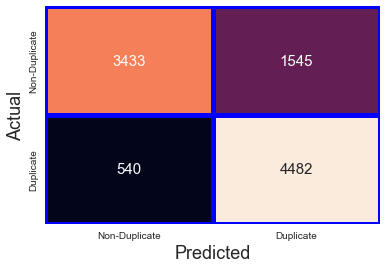

----------------------------------------------------------
Out of 10000 testing values 2085 are mis-classified.
----------------------------------------------------------
Classification Report=
               precision    recall  f1-score   support

           0       0.86      0.69      0.77      4978
           1       0.74      0.89      0.81      5022

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

----------------------------------------------------------


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
import pickle
with mlflow.start_run():
    mlflow.set_tag("Owner","Suraj H")
    mlflow.set_tag("Algorithm", "Random Forest bert extr")
    
    rf_classifier=RandomForestClassifier()
    rf_classifier.fit(x_train,y_train)
    pickle.dump(rf_classifier, open("resources_advance_approach_using_pre_trained_model/random_forest_bert_extr.pkl","wb"))
    
    y_pred=rf_classifier.predict(x_test)
    acc=accuracy_score(y_test,y_pred)
    precision=precision_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)
    
    print("----------------------------------------------------------")
    print("Acuuracy={}\nPrecission={}\nRecall={}\nF1 Score={}".format(acc, precision, recall, f1))
    print("----------------------------------------------------------")
    print("Confusion Matrix=\n")
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, annot_kws={"fontsize":15}, linewidths=5, linecolor='blue',
                yticklabels=["Non-Duplicate","Duplicate"], xticklabels=["Non-Duplicate","Duplicate"], cbar=None, fmt='g')
    plt.xlabel("Predicted",fontsize=18)
    plt.ylabel("Actual",fontsize=18)
    plt.savefig("resources_advance_approach_using_pre_trained_model/random_forest_bert_extr_conf_matrix.png")
    plt.show()
    print("----------------------------------------------------------")
    print("Out of {} testing values {} are mis-classified.".format(y_test.shape[0], sum(y_test!=y_pred)))
    print("----------------------------------------------------------")
    print("Classification Report=\n", classification_report(y_test,y_pred))
    print("----------------------------------------------------------")
    
    mlflow.log_metrics({"Accuracy":acc, "Precision":precision, "Recall":recall, "F1 Score":f1})
    mlflow.sklearn.log_model(rf_classifier, artifact_path="models")
    mlflow.log_artifact("resources_advance_approach_using_pre_trained_model/random_forest_bert_extr_conf_matrix.png")

### Highest Accuracy is 83% in XGBoost model.